In [133]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import ta







In [134]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [135]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [136]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [137]:



df = getQuotes(frameM30, 2023, 1)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0
...,...,...,...,...,...,...,...,...
8048,1692806400,1.08039,1.08291,1.08031,1.08279,4893,8,0
8049,1692808200,1.08279,1.08444,1.08251,1.08374,9913,8,0
8050,1692810000,1.08373,1.08536,1.08344,1.08493,7991,8,0
8051,1692811800,1.08494,1.08530,1.08408,1.08452,4819,8,0


In [138]:





def ichimoku(df, kijunSenLookUp = 26, tenkanSenLookup = 9, chikouSpanShift = 26, senkouSpanBLookup= 52, senkouShift = 26):
    # Tenkan Sen Calculations
    tsh = df['high'].rolling(window=tenkanSenLookup).max()
    tsl = df['low'].rolling(window=tenkanSenLookup).min()
    df['tenkan_sen'] = (tsh + tsl) / 2

    # Kijun Sen Calculations
    ksh = df['high'].rolling(window=kijunSenLookup).max()
    ksl = df['low'].rolling(window=kijunSenLookup).min()
    df['kijun_sen'] = (ksh + ksl) / 2

    # Senkou Span A Calculations
    df['senkou_span_a'] = (((df['tenkan_sen'] + df['kijun_sen']) / 2))
    
    # Senkou Span B Calculations
    ssbh = df['high'].rolling(window=senkouSpanBLookup).max()
    ssbl = df['high'].rolling(window=senkouSpanBLookup).min()
    df['senkou_span_b'] = ((ssbh + ssbl) / 2)

    # Chikou Span Calculations
    df['chikou_span'] = df['close'].shift(-chikouSpanShift)

    # Senkou Span A, Senkou Span B Shift Calculation
    emptyRows = {'senkou_span_a': [np.nan] * senkouShift, 'senkou_span_b': [np.nan] * senkouShift}
    emptyRowsDf = pd.DataFrame(emptyRows)
    df = pd.concat([df, emptyRowsDf], ignore_index=True)
    df['senkou_span_a_shifted'] = df['senkou_span_a'].shift(senkouShift)
    df['senkou_span_b_shifted'] = df['senkou_span_b'].shift(senkouShift)

    return df







In [139]:








kijunSenLookup = 26
tenkanSenLookup = 9
chikouSpanShift = 26


df = ichimoku(df, kijunSenLookup, tenkanSenLookup, chikouSpanShift)

df









,time,open,high,low,close,tick_volume,spread,real_volume,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span,senkou_span_a_shifted,senkou_span_b_shifted
0,1.672618e+09,1.06959,1.07017,1.06936,1.06937,71.0,54.0,0.0,NaN,NaN,NaN,NaN,1.06819,NaN,NaN
1,1.672619e+09,1.06936,1.06965,1.06883,1.06892,2833.0,71.0,0.0,NaN,NaN,NaN,NaN,1.06835,NaN,NaN
2,1.672621e+09,1.06892,1.06978,1.06873,1.06968,212.0,54.0,0.0,NaN,NaN,NaN,NaN,1.06837,NaN,NaN
3,1.672623e+09,1.06968,1.07021,1.06957,1.07021,208.0,54.0,0.0,NaN,NaN,NaN,NaN,1.06822,NaN,NaN
4,1.672625e+09,1.07012,1.07052,1.06953,1.06965,220.0,22.0,0.0,NaN,NaN,NaN,NaN,1.06830,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.082610,1.085035
8075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.082993,1.085035
8076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.083223,1.084995
8077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.083223,1.084075


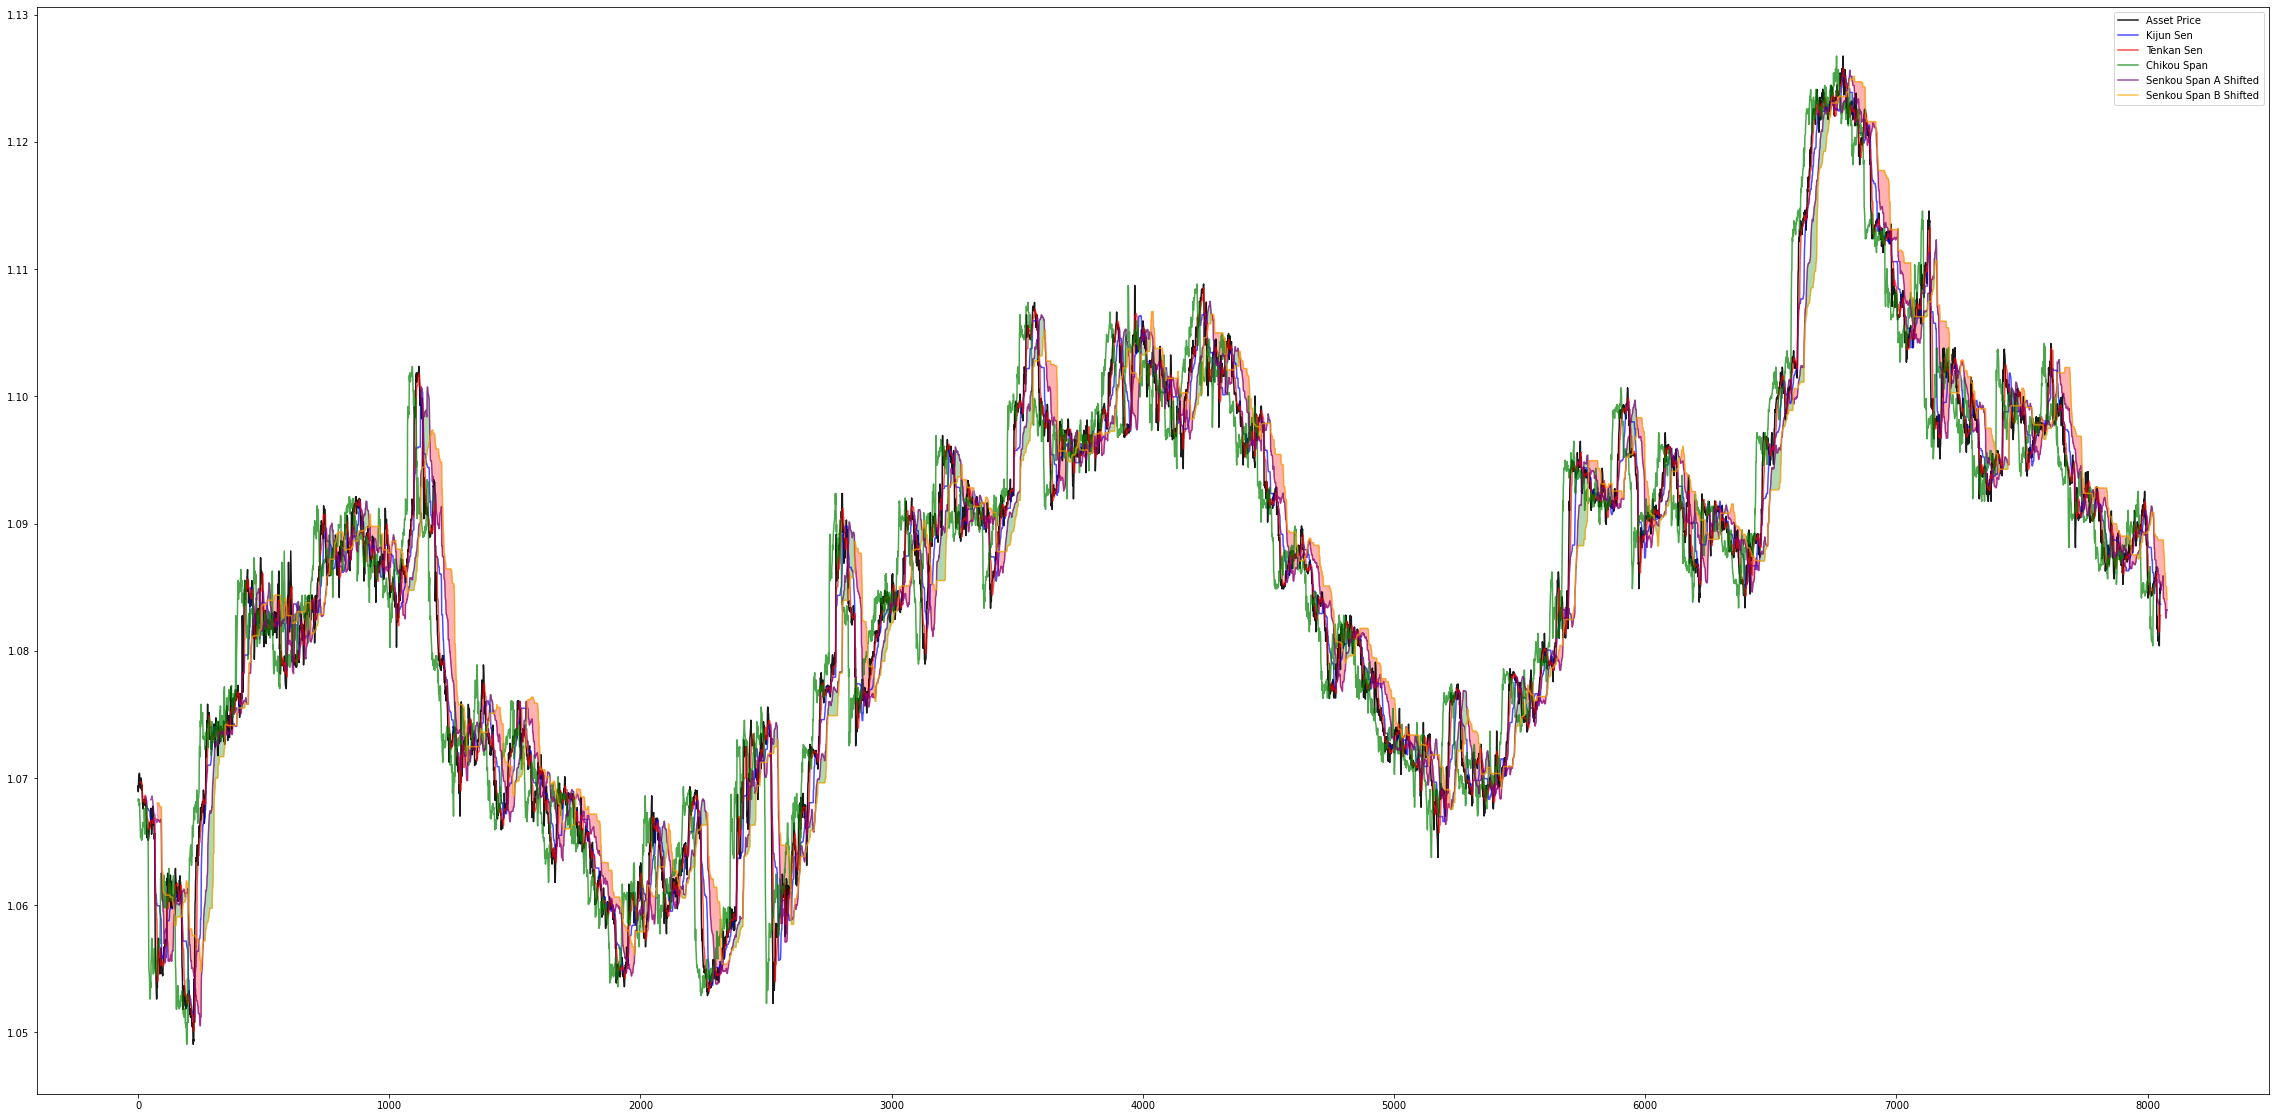

In [140]:





## Increasing the figure size
plt.figure(figsize = (40, 20))

## Plotting the Asset Price.
plt.plot(df['close'], label='Asset Price', c='black', alpha=0.9)
plt.plot(df['kijun_sen'], label='Kijun Sen', c='blue', alpha=0.7)
plt.plot(df['tenkan_sen'], label='Tenkan Sen', c='red', alpha=0.7)
plt.plot(df['chikou_span'], label='Chikou Span', c='green', alpha=0.7)
plt.plot(df['senkou_span_a_shifted'], label='Senkou Span A Shifted', c='purple', alpha=0.7)
plt.plot(df['senkou_span_b_shifted'], label='Senkou Span B Shifted', c='orange', alpha=0.7)

# Shading the region between Senkou Span A and Senkou Span B
plt.fill_between(df.index, df['senkou_span_a_shifted'], df['senkou_span_b_shifted'], where=(df['senkou_span_a_shifted'] > df['senkou_span_b_shifted']), color='green', alpha=0.3)
plt.fill_between(df.index, df['senkou_span_a_shifted'], df['senkou_span_b_shifted'], where=(df['senkou_span_a_shifted'] < df['senkou_span_b_shifted']), color='red', alpha=0.3)

# Showing the plot
plt.legend()
plt.show()








## Strategy

- A long (Buy) signal is generated whenever the Tenkan-sen crosses the Kijun-sen from the below to the above while the market price is above the chimoku cloud. And finally, the chikou span's last value must be higher than the corresponding market price in the same point in time.

- A Short (Sell) signal is generated whenever the Tenkan-sen crosses the Kijun-sen from the above to the below while the market price is below the chimoku cloud. And finally, the chikou span's last value must be lower than the corresponding market price in the same point in time.


## Some other useful resources

- https://www.pythonforfinance.net/2019/06/26/ichimoku-trading-strategy-with-python/
- https://www.pythonforfinance.net/2019/06/27/ichimoku-trading-strategy-with-python-part-2/




In [141]:




buyIndices = []
sellIndices = []
buys = []
sells = []
openPosition = None
targetPrice = None
pctRise = 0.01

for i in range(len(df)):
    
    # Optionally we can also check if senkou_span_a_shifted > senkou_span_b_shifted -> Bullish Trend
    # If senkou_span_a_shifted < senkou_span_b_shifted -> Bearish Trend
    
    if (i > 0) and (openPosition is None) and (
            (df.iloc[i]['tenkan_sen'] > df.iloc[i]['kijun_sen']) and 
            (df.iloc[i - 1]['tenkan_sen'] < df.iloc[i - 1]['kijun_sen']) and 
            (df.iloc[i]['close'] > df.iloc[i]['senkou_span_a_shifted']) and 
            (df.iloc[i]['close'] > df.iloc[i]['senkou_span_b_shifted']) and 
            (df.iloc[i]['senkou_span_a_shifted'] > df.iloc[i]['senkou_span_b_shifted']) and 
            (df.iloc[i]['chikou_span'] > df.iloc[i]['close'])
        ):
        openPosition = 'long'
        buyIndices.append(i)
        buys.append(df.iloc[i]['close'])
        targetPrice = df.iloc[i]['close'] + (pctRise * df.iloc[i]['close'])
    elif (i > 0) and (openPosition) and (
        (
            (df.iloc[i]['tenkan_sen'] < df.iloc[i]['kijun_sen']) and 
            (df.iloc[i - 1]['tenkan_sen'] > df.iloc[i - 1]['kijun_sen']) and 
            (df.iloc[i]['close'] < df.iloc[i]['senkou_span_a_shifted']) and 
            (df.iloc[i]['close'] < df.iloc[i]['senkou_span_b_shifted']) and 
            (df.iloc[i]['senkou_span_a_shifted'] < df.iloc[i]['senkou_span_b_shifted']) and 
            (df.iloc[i]['chikou_span'] < df.iloc[i]['close'])
        ) or (
            (targetPrice) and 
            (df.iloc[i]['close'] > targetPrice)
        )):
        openPosition = None
        targetPrice = None
        sellIndices.append(i)
        sells.append(df.iloc[i]['close'])







In [142]:


print(buys)
print(sells)



[1.07366, 1.08531, 1.0735, 1.05938, 1.07254, 1.09147, 1.09237, 1.09115, 1.12329, 1.08975]
[1.08483, 1.08732, 1.07146, 1.073, 1.08515, 1.10484, 1.08733, 1.10229, 1.11206]


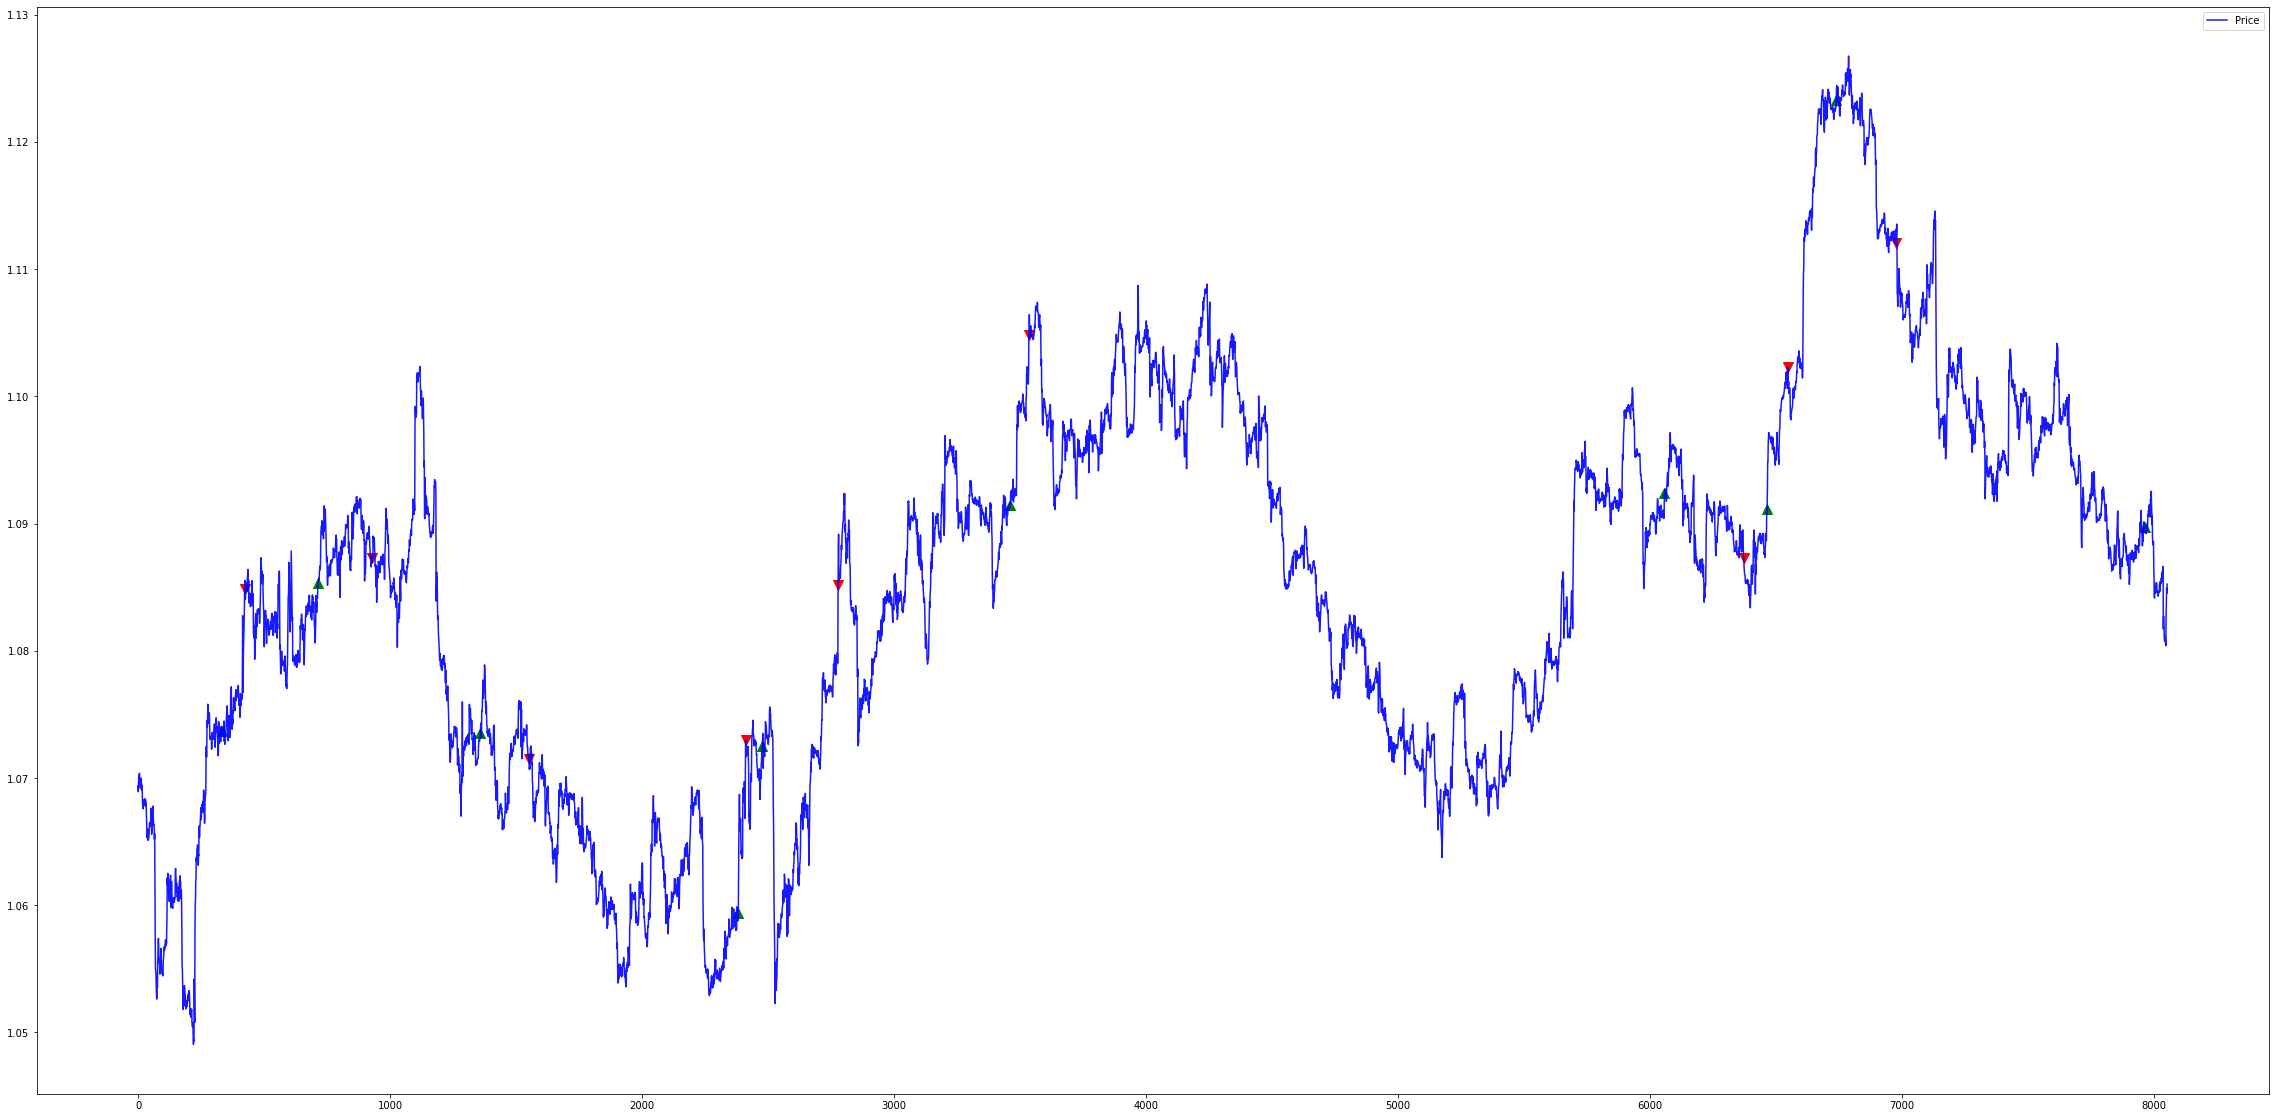

In [143]:











## Increasing the figure size
plt.figure(figsize = (40, 20))

## Plotting the Asset Price.
plt.plot(df['close'], label='Price', c='blue', alpha=0.9)
plt.scatter(df.iloc[buyIndices].index, df.iloc[buyIndices]['close'], marker = '^', color = 'g', s = 100)
plt.scatter(df.iloc[sellIndices].index, df.iloc[sellIndices]['close'], marker = 'v', color = 'r', s = 100)

# Showing the plot
plt.legend()
plt.show()














In [144]:






# P & L and other details

totalPL = 0
winTrades = 0
loseTrades = 0
maximumWin = None
maximumLose = None

for i in range(len(sells)):
    netResult = sells[i] - buys[i]

    if netResult < 0:
        loseTrades += 1
    else:
        winTrades += 1

    if not maximumWin:
        maximumWin = netResult
    elif netResult > maximumWin:
        maximumWin = netResult

    if not maximumLose:
        maximumLose = netResult
    elif netResult < maximumLose:
        maximumLose = netResult

    totalPL = totalPL + netResult
    # print(f'Net Trade Result = {netResult}')

print(f'Total P & L = {totalPL}')
print(f'Win Trades = {winTrades}')
print(f'Lose Trades = {loseTrades}')
print(f'Maximum Win = {maximumWin}')
print(f'Maximum Lose = {maximumLose}')






Total P & L = 0.04561000000000015
Win Trades = 6
Lose Trades = 3
Maximum Win = 0.013619999999999965
Maximum Lose = -0.011229999999999851
